# Detik Summarization

Program ini dirancang untuk melakukan rangkuman otomatis dari berita Detik.com. Berikut adalah langkah-langkah utama program:

1. **Crawling Berita:** Program pertama-tama melakukan pencarian dan pengambilan berita terkait dengan topik yang ditentukan dari situs Detik.com. Setiap berita kemudian diakses untuk mengekstrak informasi seperti judul, penulis, tanggal publikasi, dan isi berita.
   
2. **Ekstraksi Kalimat:** Setelah mendapatkan berita, program melakukan ekstraksi kalimat dari setiap artikel. Kalimat-kalimat ini diolah untuk mempersiapkan data input untuk langkah-langkah berikutnya.

3. **TF-IDF (Term Frequency-Inverse Document Frequency):** Program menggunakan teknik TF-IDF untuk memberikan bobot pada setiap kata dalam setiap kalimat. Ini membantu mengukur signifikansi kata dalam konteks berita tertentu.

4. **Matrix Cosine Similarity:** Matriks similaritas kosinus dibuat untuk mengukur sejauh mana setiap pasangan kalimat dalam berita mirip satu sama lain. Hal ini membantu mengidentifikasi keterkaitan antar kalimat.

5. **Pembentukan Graph:** Program menggunakan matriks similaritas untuk membentuk sebuah graf yang merepresentasikan hubungan antar kalimat. Setiap kalimat menjadi simpul, dan keberadaan edge antara simpul-simpul menunjukkan tingkat kesamaan antar kalimat.

6. **Analisis Graf:**
    - **Closeness Centrality:** Program menghitung skor Closeness Centrality untuk masing-masing simpul, yang menunjukkan seberapa dekat suatu kalimat dengan kalimat-kalimat lainnya.
    - **Eigenvector Centrality:** Program mengukur pentingnya suatu kalimat dalam jaringan dengan menghitung skor Eigenvector Centrality.
    - **Pagerank:** Pagerank dihitung untuk memberikan bobot pada setiap simpul, mencerminkan seberapa penting suatu kalimat dalam jaringan.
    - **Betweenness Centrality:** Program menghitung skor Betweenness Centrality, yang mengukur seberapa sering suatu kalimat berada pada jalur terpendek antara dua kalimat lainnya.



## Crawl Detik

Program ini, "Detik News Scraper", dirancang untuk mengambil informasi dari situs detik.com terkait topik berita yang diinginkan. Pengguna memasukkan topik, program mengambil URL berita, dan kemudian ekstrak informasi seperti judul, penulis, tanggal, dan isi berita.

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

class Detik:
    def __init__(self, topic):
        self.topic = topic
        self.df = None  # Inisialisasi DataFrame sebagai None

    def get_urls(self):
        news_links = []
        # get news URL from page 1
        page = 1
        url = f"https://www.detik.com/search/searchall?query={self.topic}&siteid=2&sortby=time&page={page}"
        html_page = requests.get(url).content
        soup = BeautifulSoup(html_page, 'lxml')
        articles = soup.find_all('article')

        # Ambil hanya satu URL berita, jika ada
        if articles:
            url = articles[0].find('a')['href']
            news_links.append(url)

        return news_links

    def has_link(self, text):
        # Fungsi untuk memeriksa apakah teks mengandung tautan
        return 'href=' in text

    def extract_news(self):
        # get news article details from scraped URLs
        scraped_info = []
        for news in self.get_urls():
            source = news
            html_page = requests.get(news).content
            soup = BeautifulSoup(html_page, 'lxml')
            # check if title, author, date, news div, is not None type
            title = soup.find('h1', class_='detail__title')
            if title is not None:
                title = title.text
                title = title.replace('\n', '')
                title = title.strip()

            author = soup.find('div', class_='detail__author')
            if author is not None:
                author = author.text

            date = soup.find('div', class_='detail__date')
            if date is not None:
                date = date.text

            # Ambil isi berita dari div dengan class 'detail__body-text itp_bodycontent'
            content_div = soup.find("div", {"class": "detail__body-text itp_bodycontent"})
            if content_div:
                # Hilangkan elemen-elemen <a> yang merupakan tautan
                for a_tag in content_div.find_all(self.has_link):
                    a_tag.decompose()

                # Ambil teks dari div
                news_content = ' '.join(content_div.stripped_strings)

                # convert scraped data into a dictionary
                news_data = {
                    "url": source,
                    "judul": title,
                    "penulis": author,
                    "tanggal": date,
                    "isi": news_content
                }
                # add dictionaries to a list
                scraped_info.append(news_data)

        self.df = pd.DataFrame.from_dict(scraped_info)
        self.df.to_csv(f'{self.topic}.csv', index=False)  # Simpan DataFrame ke dalam file CSV

# Input topik berita
topic = input("Masukkan topik berita yang ingin diambil: ")
detik_crawler = Detik(topic)
detik_crawler.extract_news()

# Setelah DataFrame df dibuat dalam metode extract_news, Anda dapat mengaksesnya di sini
detik_crawler.df


Masukkan topik berita yang ingin diambil: olahraga


,url,judul,penulis,tanggal,isi
0,https://www.detik.com/jatim/berita/d-7037716/t...,"Tinjau SMANOR Sidoarjo, Khofifah: Pusat Pencet...",Faiq Azmi - detikJatim,"Rabu, 15 Nov 2023 11:11 WIB",Surabaya - Gubernur Jatim Khofifah Indar Paraw...


## Ekstraksi Kalimat

In [18]:
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import re, string
nltk.download('punkt')  # Pastikan sudah mengunduh modul 'punkt' sebelumnya

# Fungsi untuk melakukan tokenisasi kalimat, konversi ke huruf kecil, dan menghapus tanda baca dan angka
def extract_and_preprocess_sentences(text):
    sentences = sent_tokenize(text)
    preprocessed_sentences = []

    for sentence in sentences:
        # Konversi ke huruf kecil
        sentence = sentence.lower()

        # Hapus tanda baca dan angka menggunakan regular expression
        sentence = re.sub(f"[{string.punctuation}0-9]", " ", sentence)

        # Hapus karakter '\n'
        sentence = sentence.replace('\n', ' ')

        # Hapus spasi berlebih
        sentence = ' '.join(sentence.split())

        preprocessed_sentences.append(sentence)

    return preprocessed_sentences

# Buat DataFrame baru untuk kalimat-kalimat
kalimat_df = pd.DataFrame(columns=['berita_id', 'kalimat'])

# Ekstrak dan proses setiap berita
for i in range(len(detik_crawler.df)):
    berita_id = i
    berita = detik_crawler.df.loc[i, 'isi']
    kalimat_berita = extract_and_preprocess_sentences(berita)

    # Tambahkan setiap kalimat ke DataFrame
    for kalimat in kalimat_berita:
        kalimat_df = pd.concat([kalimat_df, pd.DataFrame({'berita_id': [berita_id], 'kalimat': [kalimat]})], ignore_index=True)

# Tampilkan DataFrame dengan kolom 'berita_id' dan 'kalimat'
print(kalimat_df[['berita_id', 'kalimat']])


   berita_id                                            kalimat
0          0  surabaya gubernur jatim khofifah indar parawan...
1          0  menurut khofifah smanor merupakan salah satu s...
2          0  sebagai sekolah unggulan khofifah menyebut sma...
3          0  khofifah menyebut banyak sarana prasarana di s...
4          0  advertisement scroll to continue with content ...
5          0  karena banyak prestasi terlahir dari tempat in...
6          0  baca juga kunjungi smanor di sidoarjo khofifah...
7          0        seperti sarana prasarana untuk cabor renang
8          0  insyaallah di bagian belakang akan dibangun ko...
9          0  di samping itu ada juga cabor sepatu roda yang...
10         0  begitu pun asrama siswa yang masuk dalam perha...
11         0  catatan catatan sarana prasarana tersebut akan...
12         0  saya berharap mereka bisa beristirahat dengan ...
13         0  kemudian lanjut khofifah cabor unggulan lain y...
14         0  menurutnya beberapa cabor 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi objek TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transforms kalimat menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(kalimat_df['kalimat'])

# Dapatkan daftar fitur (kata-kata) yang terkandung dalam TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Buat DataFrame dari matriks TF-IDF dengan nama fitur sebagai kolom
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tampilkan DataFrame TF-IDF
tfidf_df


,ada,advertisement,agung,akan,apa,apbd,arahan,aries,asessment,asrama,...,ujar,unggulan,untuk,usai,video,voli,wali,with,yaitu,yang
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.253647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.185609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328965
4,0.000000,0.307156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307156,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.328103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.196002,0.000000,0.000000,0.362661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123768
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.361676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.276173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.220449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139205


## Matrix Cosinus Similarity

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Ambil matriks TF-IDF dari DataFrame
tfidf_matrix = tfidf_df.values

# Hitung kemiripan kosinus antara dokumen-dokumen
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Buat DataFrame dari matriks kemiripan kosinus
cosine_similarity_df = pd.DataFrame(cosine_similarities, columns=tfidf_df.index, index=tfidf_df.index)

cosine_similarity_df


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.000000,0.116154,0.063683,0.077215,0.000000,0.023305,0.126312,0.000000,0.028423,0.040288,...,0.056593,0.066149,0.096150,0.019797,0.098969,0.079455,0.135992,0.049225,0.000000,0.294521
1,0.116154,1.000000,0.149785,0.059079,0.087965,0.026268,0.063796,0.000000,0.000000,0.021753,...,0.034714,0.074560,0.108376,0.045566,0.033874,0.062755,0.057209,0.039107,0.000000,0.070025
2,0.063683,0.149785,1.000000,0.212421,0.000000,0.068169,0.080454,0.041750,0.023443,0.090171,...,0.046678,0.054560,0.040334,0.066001,0.116681,0.088953,0.055258,0.096718,0.162037,0.051241
3,0.077215,0.059079,0.212421,1.000000,0.000000,0.092647,0.162757,0.106261,0.028425,0.086085,...,0.169153,0.066154,0.048905,0.071499,0.179803,0.083384,0.064534,0.080928,0.251508,0.062130
4,0.000000,0.087965,0.000000,0.000000,1.000000,0.049521,0.000000,0.000000,0.000000,0.000000,...,0.050398,0.000000,0.000000,0.000000,0.000000,0.000000,0.080782,0.028388,0.059206,0.000000
5,0.023305,0.026268,0.068169,0.092647,0.049521,1.000000,0.035074,0.000000,0.000000,0.019725,...,0.053835,0.134629,0.077114,0.000000,0.035218,0.000000,0.036928,0.065093,0.063244,0.044314
6,0.126312,0.063796,0.080454,0.162757,0.000000,0.035074,1.000000,0.079958,0.191895,0.222451,...,0.084935,0.071435,0.052809,0.014898,0.082215,0.062743,0.078659,0.100169,0.082027,0.144094
7,0.000000,0.000000,0.041750,0.106261,0.000000,0.000000,0.079958,1.000000,0.159813,0.073272,...,0.000000,0.000000,0.000000,0.069110,0.108467,0.101885,0.047615,0.044831,0.129835,0.000000
8,0.028423,0.000000,0.023443,0.028425,0.000000,0.000000,0.191895,0.159813,1.000000,0.024056,...,0.029564,0.000000,0.000000,0.022690,0.000000,0.027254,0.059097,0.016652,0.000000,0.000000
9,0.040288,0.021753,0.090171,0.086085,0.000000,0.019725,0.222451,0.073272,0.024056,1.000000,...,0.129185,0.024358,0.018007,0.050972,0.061250,0.020126,0.063038,0.054504,0.027977,0.036697


## Membentuk Graph

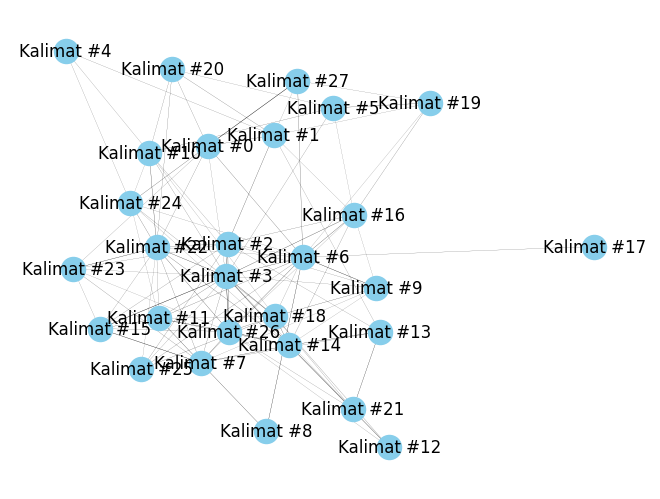

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Threshold untuk menentukan apakah akan ada edge atau tidak
threshold = 0.07

# Buat graf
G = nx.Graph()

# Tambahkan simpul (node) untuk setiap kalimat
for i in range(len(kalimat_df)):
    node_label = f"Kalimat #{i}"
    G.add_node(node_label, label=node_label)

# Tambahkan tepi (edge) antara kalimat berdasarkan skor kemiripan kosinus
for i in range(len(kalimat_df)):
    for j in range(i + 1, len(kalimat_df)):  # Hindari menghitung skor untuk diri sendiri dan duplikat
        similarity_score = cosine_similarity_df.iloc[i, j]
        if similarity_score > threshold:  # Ubah nilai threshold sesuai kebutuhan
            node_i = f"Kalimat #{i}"
            node_j = f"Kalimat #{j}"
            G.add_edge(node_i, node_j, weight=similarity_score)

# Dapatkan label dari simpul-simpul
labels = nx.get_node_attributes(G, 'label')

# Gambar graf
pos = nx.spring_layout(G)
weights = [G[u][v]['weight'] for u, v in G.edges]
nx.draw(G, pos, with_labels=True, labels=labels, width=weights, edge_cmap=plt.cm.viridis, node_color='skyblue')

plt.show()


## Closeness, Eigenvector, Pagerank, Betweenness Centrality

In [22]:
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank_centrality = nx.pagerank(G)
betweenness_centrality = nx.pagerank(G)

## Closeness Centrality

In [23]:
# Tampilkan closeness centrality dari nilai tertinggi ke terendah
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Closeness Similarity Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_closeness:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_closeness[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")


Closeness Similarity Scores (Dari Tertinggi ke Terendah):
Kalimat #3: 0.7297297297297297
Kalimat #6: 0.7105263157894737
Kalimat #22: 0.675
Kalimat #2: 0.6428571428571429
Kalimat #26: 0.6428571428571429
Kalimat #7: 0.6136363636363636
Kalimat #14: 0.6136363636363636
Kalimat #18: 0.6136363636363636
Kalimat #16: 0.6
Kalimat #11: 0.5869565217391305
Kalimat #24: 0.5869565217391305
Kalimat #0: 0.574468085106383
Kalimat #9: 0.5510204081632653
Kalimat #10: 0.5510204081632653
Kalimat #23: 0.54
Kalimat #25: 0.54
Kalimat #1: 0.5294117647058824
Kalimat #13: 0.5294117647058824
Kalimat #15: 0.5294117647058824
Kalimat #5: 0.5094339622641509
Kalimat #19: 0.5094339622641509
Kalimat #20: 0.5
Kalimat #21: 0.5
Kalimat #27: 0.4909090909090909
Kalimat #8: 0.4576271186440678
Kalimat #12: 0.4576271186440678
Kalimat #4: 0.4426229508196721
Kalimat #17: 0.421875
Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:
Kalimat #3: khofifah menyebut banyak sarana prasarana di smanor yang harus diperbaiki dir

## Pagerank Centrality

In [24]:
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

print("Pagerank Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_pagerank:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")

Pagerank Scores (Dari Tertinggi ke Terendah):
Kalimat #3: 0.08302689998944413
Kalimat #6: 0.07255119034580754
Kalimat #22: 0.060329373578159
Kalimat #14: 0.05909363087649677
Kalimat #26: 0.058793060854816385
Kalimat #7: 0.0501728140025018
Kalimat #2: 0.049483372037737866
Kalimat #18: 0.04455848120949935
Kalimat #0: 0.04125039156569538
Kalimat #11: 0.03771314623590333
Kalimat #16: 0.03581380906178136
Kalimat #15: 0.03555844318315508
Kalimat #1: 0.033553449448919935
Kalimat #10: 0.03230621063447763
Kalimat #24: 0.030057423296549427
Kalimat #9: 0.028591747083120355
Kalimat #23: 0.026638692412697684
Kalimat #27: 0.025976658107967
Kalimat #21: 0.02577043859808685
Kalimat #13: 0.024926559243097057
Kalimat #5: 0.02261671984842958
Kalimat #20: 0.022319374546894626
Kalimat #19: 0.02219343645911326
Kalimat #25: 0.01980662918276906
Kalimat #12: 0.017492298830239925
Kalimat #8: 0.016458010963524384
Kalimat #4: 0.014369931275105503
Kalimat #17: 0.008577807128009773
Tiga Kalimat Teratas dari Nilai T

## Eigenvector Centrality

In [25]:
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

print("eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_eigenvector:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")

eigenvector Scores (Dari Tertinggi ke Terendah):
Kalimat #3: 0.35467476524052427
Kalimat #22: 0.30186269048300896
Kalimat #6: 0.29952591819141205
Kalimat #26: 0.2972883713825552
Kalimat #14: 0.25468607596953696
Kalimat #2: 0.24977446963096742
Kalimat #7: 0.24598108108449204
Kalimat #11: 0.23537476351212622
Kalimat #18: 0.2327300041167668
Kalimat #16: 0.19036338055383364
Kalimat #15: 0.18741540728970427
Kalimat #9: 0.18366817407986913
Kalimat #23: 0.18007133140122808
Kalimat #24: 0.16812204799250852
Kalimat #0: 0.15494533164501526
Kalimat #10: 0.1521188891308409
Kalimat #25: 0.1445610438894658
Kalimat #21: 0.1336618034039076
Kalimat #13: 0.09844753060466419
Kalimat #1: 0.09557664841972925
Kalimat #12: 0.09228565834759131
Kalimat #5: 0.08544261363542098
Kalimat #20: 0.07938203023952761
Kalimat #19: 0.073719038398789
Kalimat #27: 0.06268277150143281
Kalimat #8: 0.0548177108455481
Kalimat #4: 0.04178571765567238
Kalimat #17: 0.030099302195523567
Tiga Kalimat Teratas dari Nilai Tertinggi Cl

## Betweenes Centrality

In [26]:
sorted_betweeness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_betweeness:
    print(f"{node}: {score}")

# Tampilkan 3 kalimat teratas dari nilai tertinggi
top_3_nodes = sorted_betweeness[:3]

print("Tiga Kalimat Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    kalimat_index = int(node.split("#")[1])  # Mendapatkan indeks kalimat dari simpul
    kalimat = kalimat_df['kalimat'][kalimat_index]
    print(f"Kalimat #{kalimat_index}: {kalimat}")




eigenvector Scores (Dari Tertinggi ke Terendah):
Kalimat #3: 0.08302689998944413
Kalimat #6: 0.07255119034580754
Kalimat #22: 0.060329373578159
Kalimat #14: 0.05909363087649677
Kalimat #26: 0.058793060854816385
Kalimat #7: 0.0501728140025018
Kalimat #2: 0.049483372037737866
Kalimat #18: 0.04455848120949935
Kalimat #0: 0.04125039156569538
Kalimat #11: 0.03771314623590333
Kalimat #16: 0.03581380906178136
Kalimat #15: 0.03555844318315508
Kalimat #1: 0.033553449448919935
Kalimat #10: 0.03230621063447763
Kalimat #24: 0.030057423296549427
Kalimat #9: 0.028591747083120355
Kalimat #23: 0.026638692412697684
Kalimat #27: 0.025976658107967
Kalimat #21: 0.02577043859808685
Kalimat #13: 0.024926559243097057
Kalimat #5: 0.02261671984842958
Kalimat #20: 0.022319374546894626
Kalimat #19: 0.02219343645911326
Kalimat #25: 0.01980662918276906
Kalimat #12: 0.017492298830239925
Kalimat #8: 0.016458010963524384
Kalimat #4: 0.014369931275105503
Kalimat #17: 0.008577807128009773
Tiga Kalimat Teratas dari Nila